In [1]:
import cv2
import os
import random
import glob as gb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import zipfile
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import *

In [2]:
zip_file_path = 'MoodforMusic.zip'
extract_to_path = 'MoodforMusic'
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to_path)
extracted_files = os.listdir(extract_to_path)
print(extracted_files)

['data_moods.csv', 'test', 'train']


In [3]:
train_data="../MoodforMusic/train/"
test_data="../MoodforMusic/test/"

def Classes_Count(path, name):
    Classes_Dict={}
    for Class in os.listdir(path):
        Full_Path = path+Class
        Classes_Dict[Class]=len(os.listdir(Full_Path))
    df=pd.DataFrame(Classes_Dict, index=[name])
    return df

Train_Count= Classes_Count(train_data, "Train").transpose().sort_values(by="Train",ascending=False)
Test_Count= Classes_Count(test_data, "Test").transpose().sort_values(by="Test",ascending=False)

In [4]:
pd.concat([Train_Count,Test_Count], axis=1)

,Train,Test
happy,7215,1774
neutral,4965,1233
sad,4830,1248
fear,4097,1024
angry,3995,958
surprise,3171,831
disgust,436,111


<Axes: >

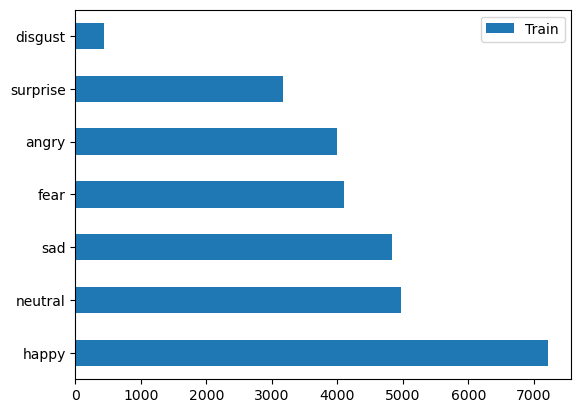

In [5]:
Train_Count.plot(kind="barh")

<Axes: >

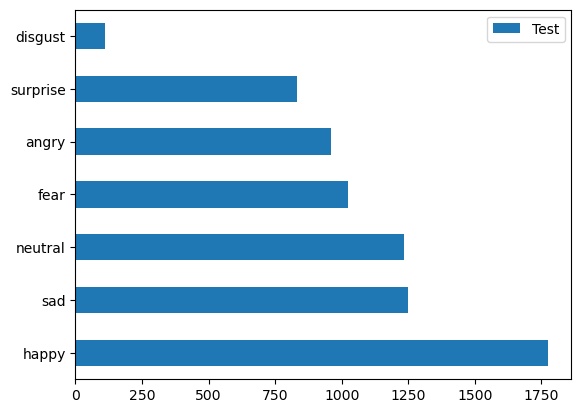

In [6]:
Test_Count.plot(kind="barh")

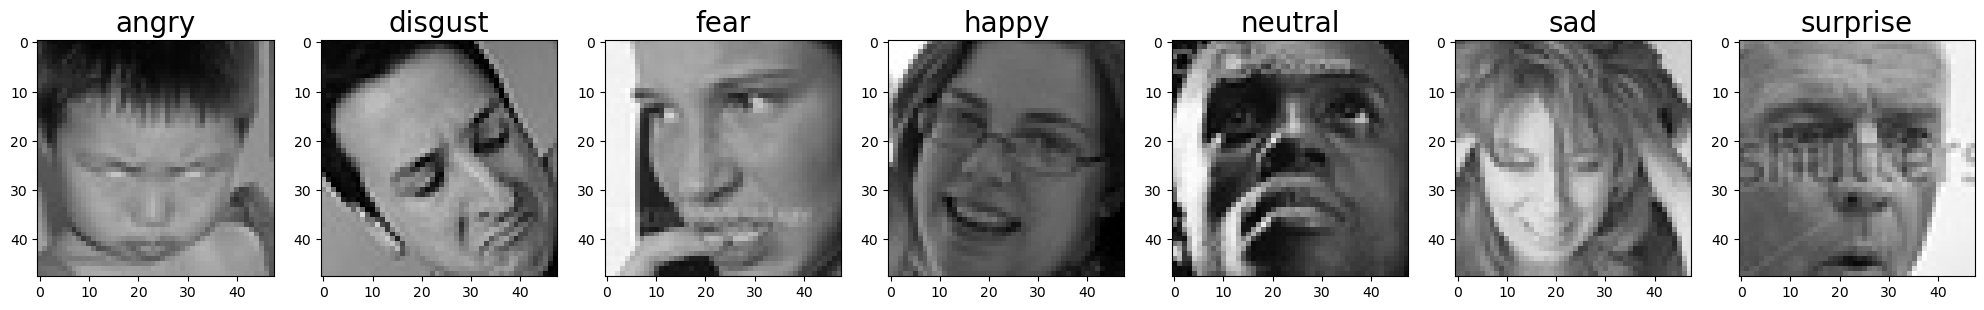

In [7]:
plt.style.use("default")
plt.figure(figsize=(25,8))
image_count=1
BASE_URL = "../MoodforMusic/train/"

for directory in os.listdir(BASE_URL):
    if directory[0] != ".":
        for i, file in enumerate(os.listdir(BASE_URL + directory)):
            if i == 1:
                break
            else:
                fig = plt.subplot(1,7, image_count)
                image_count+=1
                image=cv2.imread(BASE_URL+directory+"/"+file)
                plt.imshow(image)
                plt.title(directory, fontsize=20)

In [8]:
img_shape=48
batch_size=32
train_data_path="../MoodforMusic/train/"
test_data_path="../MoodforMusic/test/"

In [9]:
train_preprocessor = ImageDataGenerator(
    rescale=1.0/255.0, 
    rotation_range=10, 
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode="nearest")

test_preprocessor = ImageDataGenerator(
    rescale=1.0/255.0)

training_data = train_preprocessor.flow_from_directory(
    train_data_path,
    class_mode='categorical',
    target_size=(img_shape, img_shape),
    batch_size=batch_size,
    color_mode="rgb",
    shuffle=True,
    subset="training"
)

testing_data = test_preprocessor.flow_from_directory(
    test_data_path,
    class_mode='categorical',
    target_size=(img_shape, img_shape),
    batch_size=batch_size,
    color_mode="rgb",
    shuffle=False,
)

Found 28709 images belonging to 7 classes.
Found 7179 images belonging to 7 classes.


In [10]:
def Create_CNN_Model():
    model=keras.Sequential()
    model.add(Conv2D(32,(3,3),activation="relu", input_shape=(img_shape, img_shape,3)))
    model.add(BatchNormalization())
    model.add(Conv2D(64,(3,3),activation="relu", padding="same"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), padding="same"))
    model.add(Dropout(0.25))
    model.add(Conv2D(64,(3,3),activation="relu"))
    model.add(BatchNormalization())
    model.add(Conv2D(128,(3,3),activation="relu", padding="same"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), padding="same"))
    model.add(Dropout(0.25))
    model.add(Conv2D(128,(3,3),activation="relu"))
    model.add(BatchNormalization())
    model.add(Conv2D(256,(3,3),activation="relu", padding="same"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), padding="same"))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Dense(32, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Dense(7,activation='softmax'))
    return model    

In [11]:
CNN_Model=Create_CNN_Model()
CNN_Model.summary()
CNN_Model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 46, 46, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 46, 46, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 46, 46, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 46, 46, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 21, 21, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 21, 21, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 21, 21, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 21, 21, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 11, 11, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 11, 11, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 9, 9, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 9, 9, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 9, 9, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 9, 9, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,638,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 2,259,655 (8.62 MB)

 Trainable params: 2,257,351 (8.61 MB)

 Non-trainable params: 2,304 (9.00 KB)

In [12]:
checkpoint_path="CNN_Model_Checkpoint.keras"
Checkpoint=ModelCheckpoint(checkpoint_path,monitor="val_accuracy",save_best_only=True)
Early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True, verbose=1)
Reducing_LR=tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",factor=0.2,patience=2,min_lr=0.000005, verbose=1)
callbacks=[Early_stopping, Reducing_LR]
steps_per_epoch=training_data.n//training_data.batch_size
validation_steps=testing_data.n//testing_data.batch_size

In [13]:
CNN_history=CNN_Model.fit(training_data,validation_data=testing_data,epochs=35, batch_size=batch_size, 
                          callbacks=callbacks, steps_per_epoch=steps_per_epoch, validation_steps=validation_steps)

Epoch 1/35
897/897 ━━━━━━━━━━━━━━━━━━━━ 105s 111ms/step - accuracy: 0.1983 - loss: 2.1766 - val_accuracy: 0.2390 - val_loss: 1.8267 - learning_rate: 0.0010
Epoch 2/35
897/897 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.2188 - loss: 1.8747 - val_accuracy: 0.2450 - val_loss: 1.8187 - learning_rate: 0.0010
Epoch 3/35
897/897 ━━━━━━━━━━━━━━━━━━━━ 114s 127ms/step - accuracy: 0.2914 - loss: 1.7393 - val_accuracy: 0.4064 - val_loss: 1.5176 - learning_rate: 0.0010
Epoch 4/35
897/897 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.3438 - loss: 1.5497 - val_accuracy: 0.4051 - val_loss: 1.5188 - learning_rate: 0.0010
Epoch 5/35
897/897 ━━━━━━━━━━━━━━━━━━━━ 123s 137ms/step - accuracy: 0.3769 - loss: 1.5783 - val_accuracy: 0.4639 - val_loss: 1.3959 - learning_rate: 0.0010
Epoch 6/35
897/897 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.3438 - loss: 1.5689 - val_accuracy: 0.4590 - val_loss: 1.4150 - learning_rate: 0.0010
Epoch 7/35
897/897 ━━━━━━━━━━━━━━━━━━━━ 122s 136ms/step - accuracy: 0.4342 

In [20]:
CNN_Model.save('CNN_Model.keras')

In [14]:
test_loss, test_acc = CNN_Model.evaluate(testing_data)
print(f'Test accuracy: {test_acc:.2f}')

225/225 ━━━━━━━━━━━━━━━━━━━━ 13s 56ms/step - accuracy: 0.5496 - loss: 1.1515
Test accuracy: 0.62


In [15]:
def plot_curves(history):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]
    epochs = range(len(history.history["loss"]))
    
    plt.figure(figsize=(15, 5))
    
    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="training_loss")
    plt.plot(epochs, val_loss, label="val_loss")
    plt.title("Loss")
    plt.xlabel("epochs")
    plt.legend()
    
    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="training_accuracy")
    plt.plot(epochs, val_accuracy, label="val_accuracy")
    plt.title("Accuracy")
    plt.xlabel("epochs")
    plt.legend()
    
    plt.show()

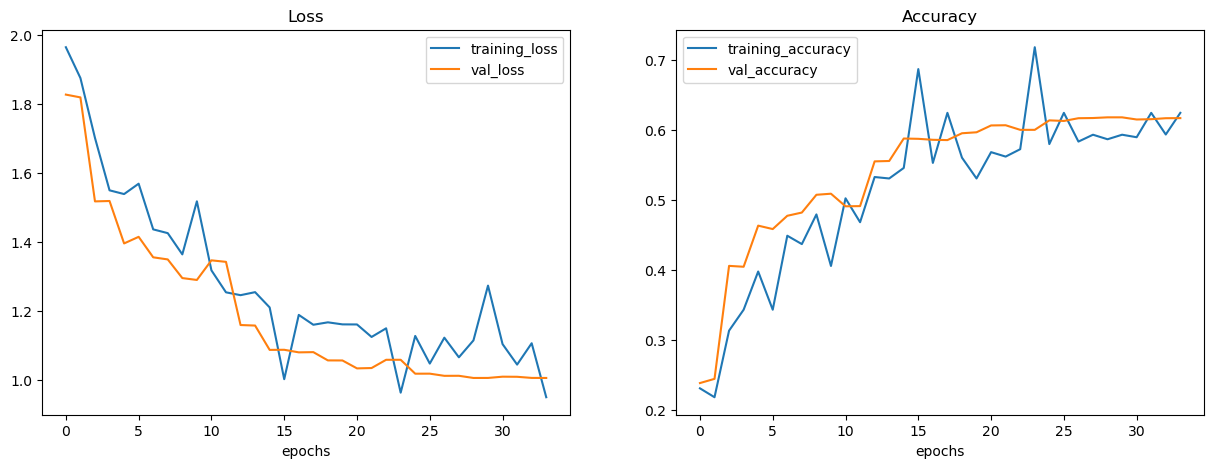

In [16]:
plot_curves(CNN_history)

In [17]:
CNN_Predictions=CNN_Model.predict(testing_data)
CNN_Predictions=np.argmax(CNN_Predictions,axis=1)

225/225 ━━━━━━━━━━━━━━━━━━━━ 12s 53ms/step


In [18]:
testing_data.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

Text(0.5, 1.0, 'CNN Confusion Matrix')

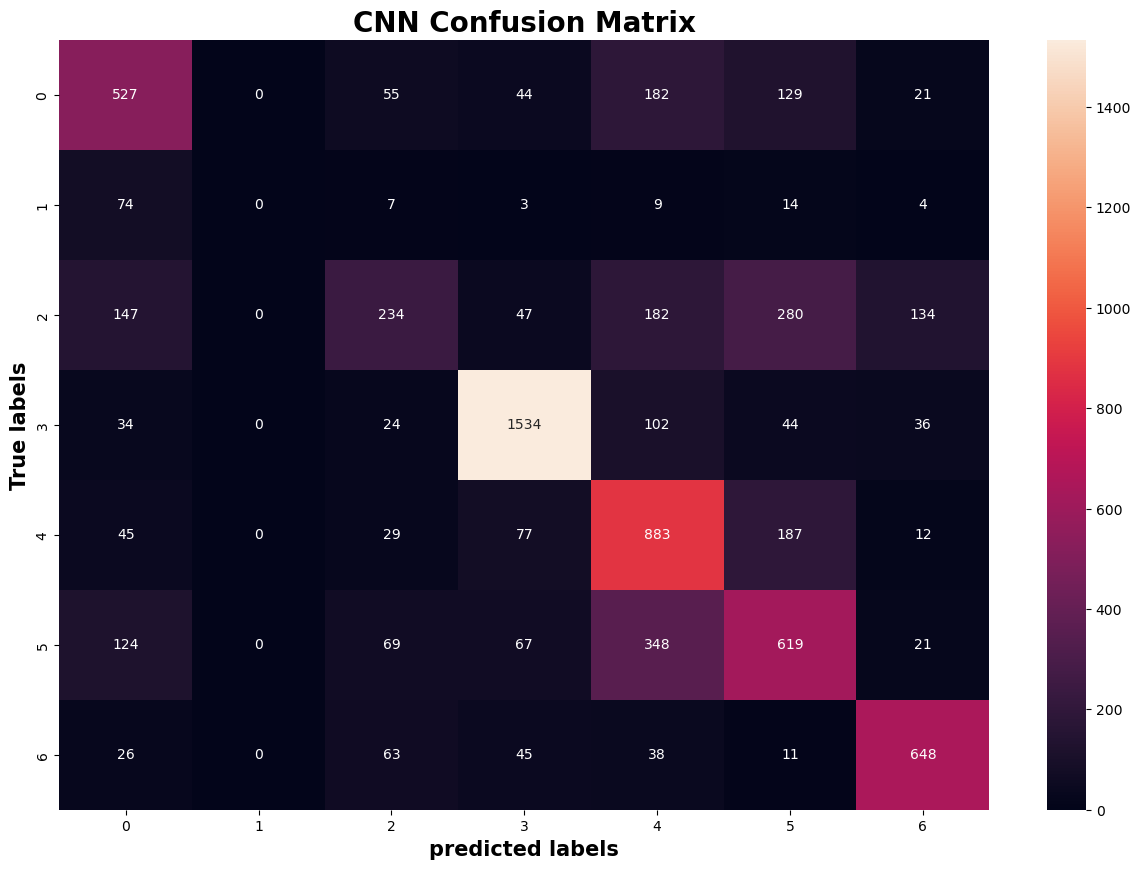

In [19]:
fig, ax=plt.subplots(figsize=(15,10))
cm=confusion_matrix(testing_data.labels,CNN_Predictions)
sns.heatmap(cm, annot=True, fmt="g", ax=ax)
ax.set_xlabel("predicted labels",fontsize=15, fontweight="bold")
ax.set_ylabel("True labels",fontsize=15, fontweight="bold")
ax.set_title("CNN Confusion Matrix",fontsize=20, fontweight="bold")